In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("../../dataset/cleaned_bank.csv", delimiter=',')
data.info()

# Separate target from the features
X = data.copy()
y = X.pop("y")  # target feature

# One-hot encoding for categorical variables
data = pd.get_dummies(data, columns=['contact'], drop_first=False) # Drop_first=False keeps all categories

# Check if all discrete features are integers
discrete_features = X.dtypes.apply(lambda dtype: np.issubdtype(dtype, np.integer))

print(data.columns)


C:\Users\josia\AppData\Local\Temp\ipykernel_26628\1253615218.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2403 entries, 0 to 2402
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        2403 non-null   int64  
 1   job        2403 non-null   object 
 2   marital    2403 non-null   object 
 3   education  2403 non-null   object 
 4   default    2403 non-null   object 
 5   balance    2403 non-null   float64
 6   housing    2403 non-null   object 
 7   loan       2403 non-null   object 
 8   contact    2403 non-null   object 
 9   day        2403 non-null   int64  
 10  month      2403 non-null   object 
 11  duration   2403 non-null   int64  
 12  campaign   2403 non-null   int64  
 13  pdays      2403 non-null   int64  
 14  previous   2403 non-null   int64  
 15  poutcome   2403 non-null   object 
 16  y          2403 non-null   object 
dtypes: float64(1), int64(6), object(10)
memory usage: 319.3+ KB
Index(['age', 'job', 'marital', 'education', 'default', 'balance', '

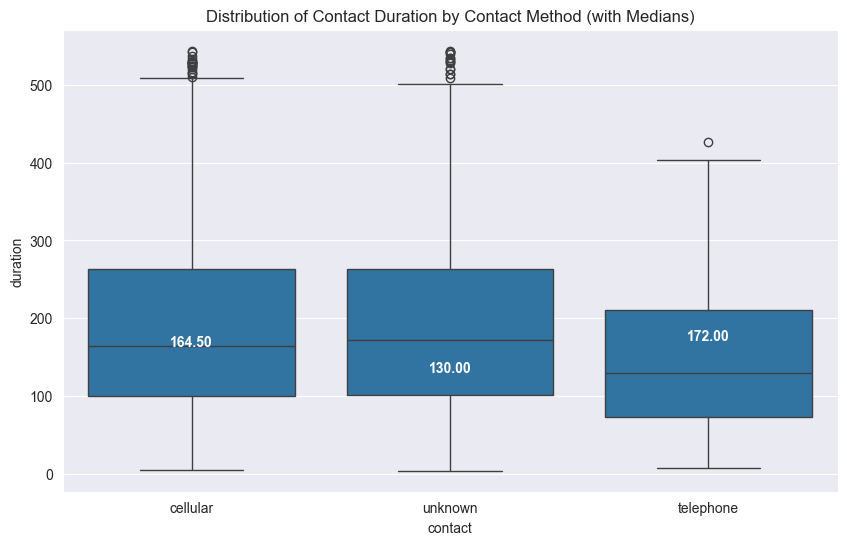

In [24]:
import seaborn as sns

# Create the box plot
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='contact', y='duration', data=X)

# Calculate medians for each contact method
medians = X.groupby(['contact'])['duration'].median()

# Add median values as text labels on the plot
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.2f}', horizontalalignment='center', color='white', weight='semibold')

# Set the title and show the plot
plt.title('Distribution of Contact Duration by Contact Method (with Medians)')
plt.show()



In [ ]:
import scipy.stats as stats

# Perform a test to check if duration varies by contact method
anova_result = stats.f_oneway(data[data['contact'] == 'cellular']['duration'],
                              data[data['contact'] == 'telephone']['duration'],
                              data[data['contact'] == 'unknown']['duration'])

print(' F-statistic:', anova_result.statistic)
print(' p-value:', anova_result.pvalue)


F-statistic: Measures how different the means are across the groups. A larger value indicates more variance between groups. The value in our case is relatively high which means that duration varies across different contact methods.
p-value: The p-value is less than 0.005 that suggests that there are significant differences in the duration across different contact methods.

Conclusion:
Distribution diagram as well as F-statistic and p-value shows that contact method impacts the duration of the call.

In [22]:
# Create interaction features between 'duration' and one-hot encoded contact columns
data['duration_contact_cellular'] = data['duration'] * data['contact_cellular']
data['duration_contact_telephone'] = data['duration'] * data['contact_telephone']
data['duration_contact_unknown'] = data['duration'] * data['contact_unknown']

# Calculate the median duration for each contact method
# For each one-hot encoded contact type, calculate the median of 'duration'
median_cellular = data[data['contact_cellular'] == 1]['duration'].median()
median_telephone = data[data['contact_telephone'] == 1]['duration'].median()
median_unknown = data[data['contact_unknown'] == 1]['duration'].median()

# Create the 'above_median_duration' feature based on one-hot encoded contact types
data['above_median_duration'] = data.apply(
    lambda row: 1 if (
        (row['contact_cellular'] == 1 and row['duration'] > median_cellular) or
        (row['contact_telephone'] == 1 and row['duration'] > median_telephone) or
        (row['contact_unknown'] == 1 and row['duration'] > median_unknown)
    ) else 0, axis=1
)
print(data.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'y', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'duration_contact_cellular',
       'duration_contact_telephone', 'duration_contact_unknown',
       'above_median_duration'],
      dtype='object')


In [25]:
import pandas as pd
import numpy as np

# Assuming 'data' is your DataFrame, if not, load the data
# data = pd.read_csv('path_to_your_dataset.csv')

# Normalize/scale 'balance' (optional: this helps to ensure balance values are comparable with other features)
data['scaled_balance'] = (data['balance'] - data['balance'].min()) / (data['balance'].max() - data['balance'].min())

# Assign penalties for having loans and default status
data['housing_penalty'] = data['housing'].apply(lambda x: -1 if x == 'yes' else 0)
data['loan_penalty'] = data['loan'].apply(lambda x: -1 if x == 'yes' else 0)
data['default_penalty'] = data['default'].apply(lambda x: -2 if x == 'yes' else 0)

# Assign job scores (higher for high-income jobs)
job_scores = {
    'management': 2, 'entrepreneur': 2, 'self-employed': 1, 'technician': 1,
    'services': 0, 'admin.': 0, 'student': 1, 'blue-collar': -1,
    'unemployed': -2, 'retired': -1, 'housemaid': -1, 'unknown': 0
}
data['job_score'] = data['job'].map(job_scores)

# Create the Financial Stability Index (FSI)
data['FSI'] = (data['scaled_balance'] + data['job_score']
               + data['housing_penalty'] + data['loan_penalty'] + data['default_penalty'])

# Now the FSI has been added to the dataset as a new column

# Show the first few rows including FSI
print(data[['balance', 'housing', 'loan', 'default', 'job', 'FSI']].head())

data.to_csv('dataset_with_FSI.csv', index=False)
data

   balance housing loan default           job       FSI
0   1787.0      no   no      no    unemployed -1.160932
1   1476.0     yes  yes      no    management  0.754809
2      0.0     yes   no      no   blue-collar -1.645083
3    147.0     yes   no      no    technician  0.394744
4    221.0     yes   no      no  entrepreneur  1.414793


,age,job,marital,education,default,balance,housing,loan,day,month,...,campaign,contact_cellular,contact_telephone,contact_unknown,scaled_balance,housing_penalty,loan_penalty,default_penalty,job_score,FSI
0,30,unemployed,married,primary,no,1787.0,no,no,19,oct,...,1,True,False,False,0.839068,0,0,0,-2,-1.160932
1,30,management,married,tertiary,no,1476.0,yes,yes,3,jun,...,4,False,False,True,0.754809,-1,-1,0,2,0.754809
2,59,blue-collar,married,secondary,no,0.0,yes,no,5,may,...,1,False,False,True,0.354917,-1,0,0,-1,-1.645083
3,39,technician,married,secondary,no,147.0,yes,no,6,may,...,2,True,False,False,0.394744,-1,0,0,1,0.394744
4,41,entrepreneur,married,tertiary,no,221.0,yes,no,14,may,...,2,False,False,True,0.414793,-1,0,0,2,1.414793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398,33,services,married,secondary,no,288.0,yes,no,17,apr,...,3,True,False,False,0.432945,-1,0,0,0,-0.567055
2399,42,admin.,married,unknown,no,642.0,yes,yes,16,may,...,2,False,False,True,0.528854,-1,-1,0,0,-1.471146
2400,36,technician,divorced,secondary,no,566.0,yes,no,20,may,...,2,False,False,True,0.508263,-1,0,0,1,0.508263
2401,49,blue-collar,married,secondary,no,322.0,no,no,14,aug,...,2,True,False,False,0.442157,0,0,0,-1,-0.557843
